In [1]:
"""Data Loading & Exploration"""
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

C:\Users\ajayv\AppData\Roaming\Python\Python311\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
# Set visualization style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

In [3]:
# 1. Load the dataset
file_path = 'diabetes+130-us+hospitals+for+years+1999-2008\diabetic_data.csv'
df = pd.read_csv(file_path, na_values='?')


C:\Users\ajayv\AppData\Local\Temp\ipykernel_18472\771314442.py:3: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path, na_values='?')


Step 2: Data Loading & Exploration

Dataset shape: (101766, 50)

First 5 rows:
   encounter_id  patient_nbr             race  gender      age weight  \
0       2278392      8222157        Caucasian  Female   [0-10)    NaN   
1        149190     55629189        Caucasian  Female  [10-20)    NaN   
2         64410     86047875  AfricanAmerican  Female  [20-30)    NaN   
3        500364     82442376        Caucasian    Male  [30-40)    NaN   
4         16680     42519267        Caucasian    Male  [40-50)    NaN   

   admission_type_id  discharge_disposition_id  admission_source_id  \
0                  6                        25                    1   
1                  1                         1                    7   
2                  1                         1                    7   
3                  1                         1                    7   
4                  1                         1                    7   

   time_in_hospital  ... citoglipton insulin  glyburide

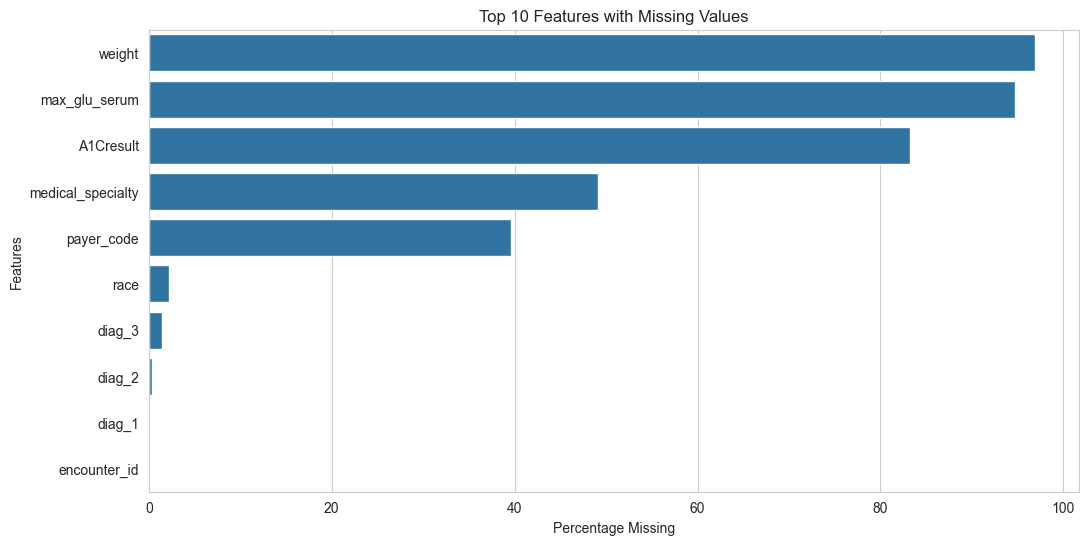

In [4]:
# 2. Initial Exploration
print("="*50)
print("Step 2: Data Loading & Exploration")
print("="*50)

# Basic dataset info
print(f"\nDataset shape: {df.shape}")
print("\nFirst 5 rows:")
print(df.head())
print("\nData types:")
print(df.dtypes.value_counts())

# Missing value analysis
missing_values = df.isnull().sum().sort_values(ascending=False)
missing_pct = (missing_values / len(df)) * 100
missing_df = pd.concat([missing_values, missing_pct], axis=1, keys=['Count', '%'])
print("\nMissing values:")
print(missing_df.head(10))

# Visualize missing values
plt.figure(figsize=(12, 6))
sns.barplot(x=missing_pct.head(10).values, y=missing_pct.head(10).index)
plt.title('Top 10 Features with Missing Values')
plt.xlabel('Percentage Missing')
plt.ylabel('Features')
plt.show()


Target variable distribution:
readmitted
NO     0.539119
>30    0.349282
<30    0.111599
Name: proportion, dtype: float64

Numerical features summary:
                             count          mean           std      min  \
encounter_id              101766.0  1.652016e+08  1.026403e+08  12522.0   
patient_nbr               101766.0  5.433040e+07  3.869636e+07    135.0   
admission_type_id         101766.0  2.024006e+00  1.445403e+00      1.0   
discharge_disposition_id  101766.0  3.715642e+00  5.280166e+00      1.0   
admission_source_id       101766.0  5.754437e+00  4.064081e+00      1.0   
time_in_hospital          101766.0  4.395987e+00  2.985108e+00      1.0   
num_lab_procedures        101766.0  4.309564e+01  1.967436e+01      1.0   
num_procedures            101766.0  1.339730e+00  1.705807e+00      0.0   
num_medications           101766.0  1.602184e+01  8.127566e+00      1.0   
number_outpatient         101766.0  3.693572e-01  1.267265e+00      0.0   
number_emergency       

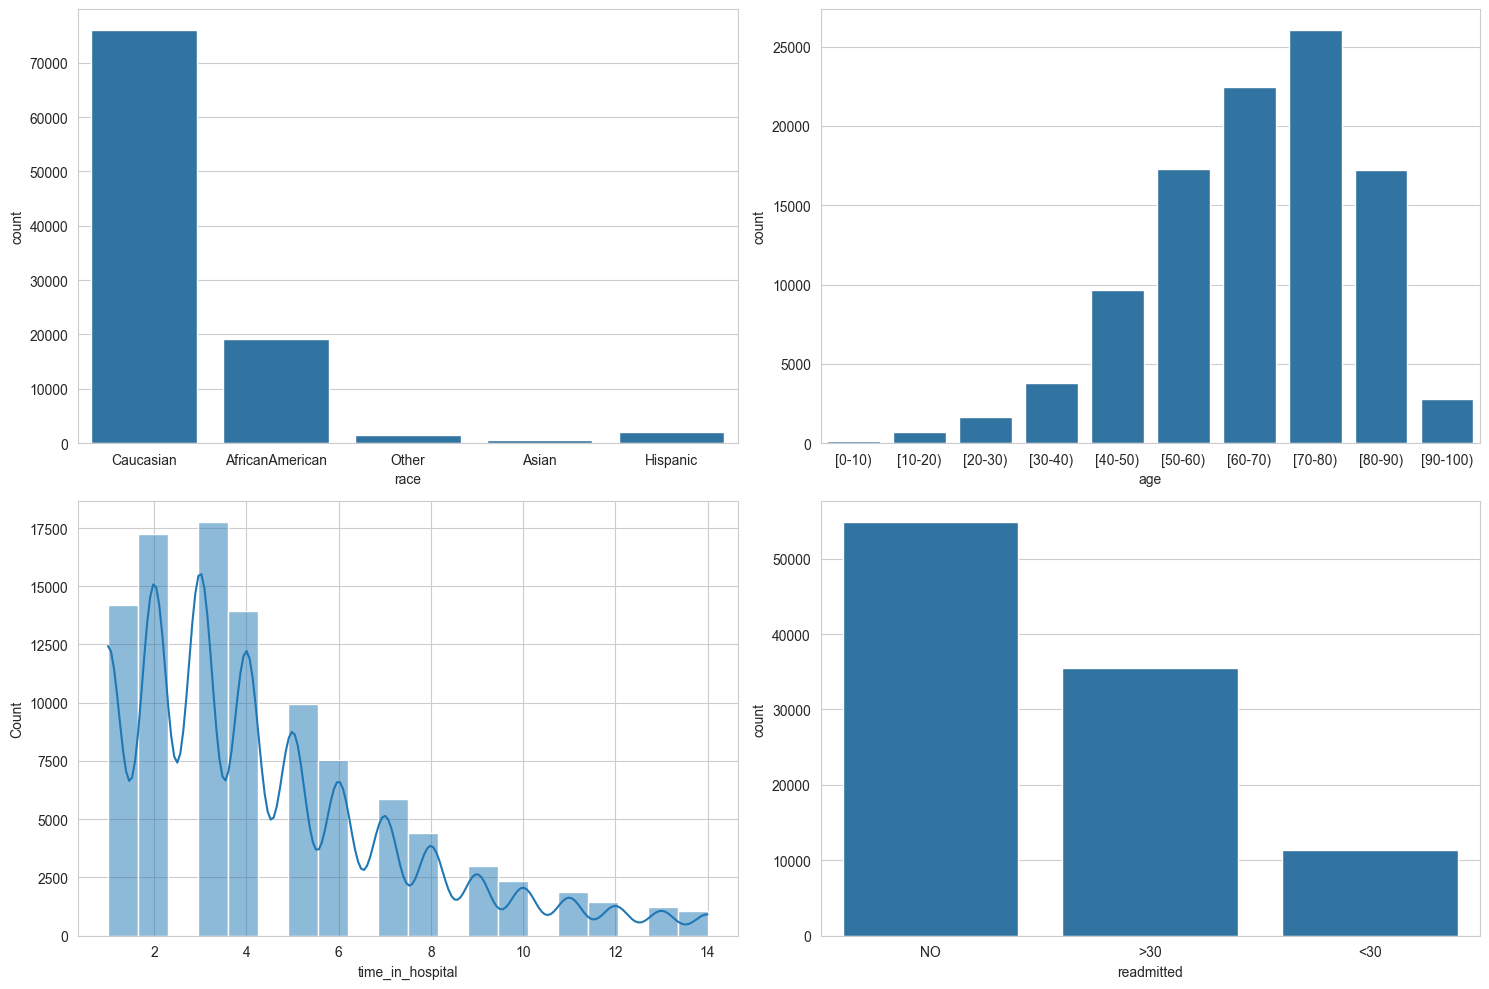

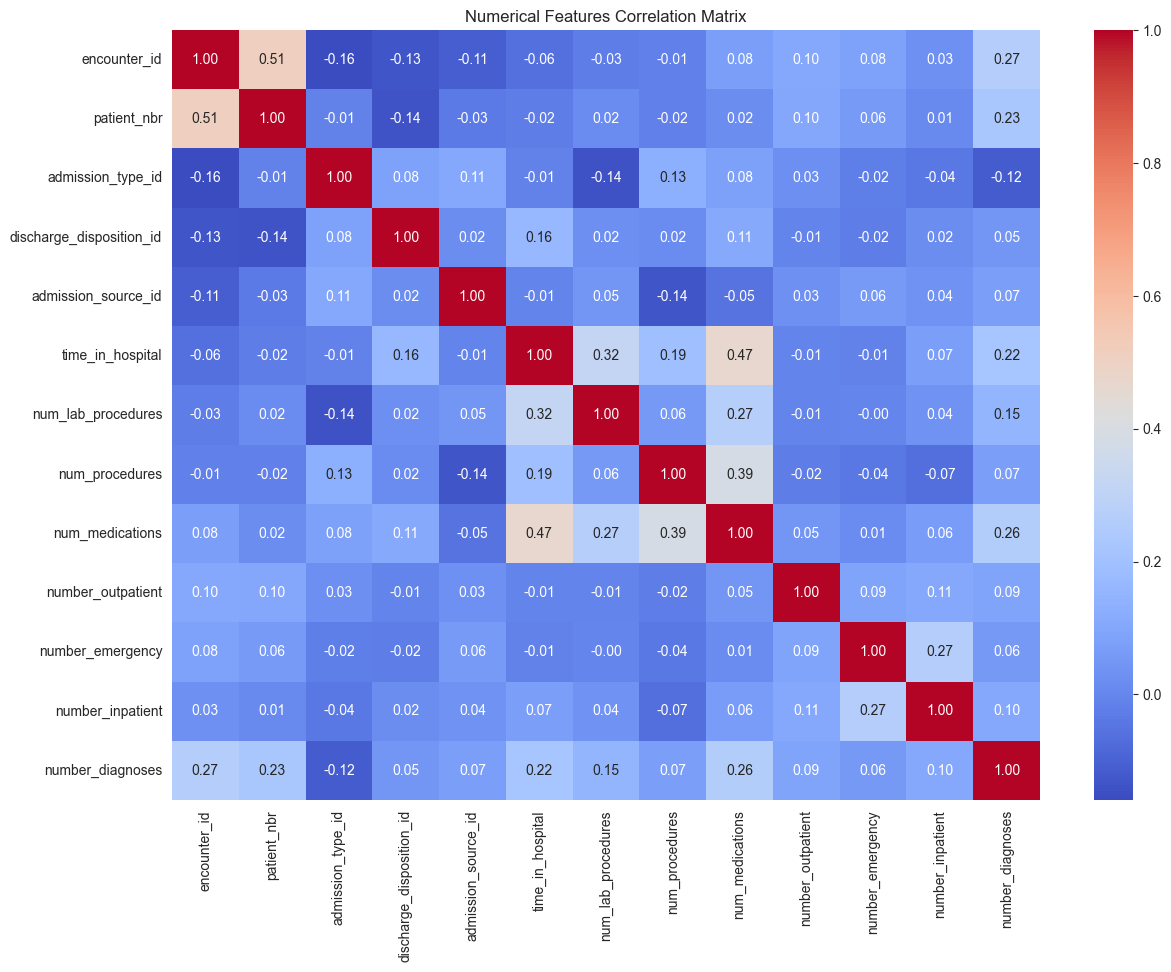

In [5]:
# Target distribution
print("\nTarget variable distribution:")
print(df['readmitted'].value_counts(normalize=True))

# Numerical features summary
print("\nNumerical features summary:")
print(df.select_dtypes(include=np.number).describe().transpose())

# Categorical features summary
cat_cols = df.select_dtypes(include='object').columns
print("\nCategorical features summary:")
for col in cat_cols:
    print(f"\n{col}:")
    print(df[col].value_counts().head())

# Distribution plots
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
sns.countplot(x='race', data=df, ax=axes[0, 0])
sns.countplot(x='age', data=df, order=sorted(df['age'].unique()), ax=axes[0, 1])
sns.histplot(df['time_in_hospital'], bins=20, kde=True, ax=axes[1, 0])
sns.countplot(x='readmitted', data=df, ax=axes[1, 1])
plt.tight_layout()
plt.show()

# Correlation matrix
plt.figure(figsize=(14, 10))
corr_matrix = df.select_dtypes(include=np.number).corr()
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Numerical Features Correlation Matrix')
plt.show()


In [6]:
"""Step 3: Data Preprocessing"""
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# 1. Data Cleaning
print("="*50)
print("Step 3: Data Preprocessing")
print("="*50)

# Drop high-missing columns
df.drop(['weight', 'payer_code', 'medical_specialty'], axis=1, inplace=True)
print("Dropped columns with >40% missing values")

# Remove invalid records
df = df[df['gender'] != 'Unknown/Invalid']
df.dropna(subset=['race', 'diag_1', 'diag_2', 'diag_3'], inplace=True)

# Remove deceased patients
expired_ids = [11, 13, 14, 19, 20, 21]
df = df[~df['discharge_disposition_id'].isin(expired_ids)]

# Handle duplicates
df.drop_duplicates(subset=['patient_nbr'], keep='first', inplace=True)

# Drop identifiers
df.drop(['encounter_id', 'patient_nbr'], axis=1, inplace=True)

Step 3: Data Preprocessing
Dropped columns with >40% missing values


In [7]:
# 2. Feature Engineering
# Create target variable
df['readmitted'] = (df['readmitted'] == '<30').astype(int)

# Diagnosis grouping function
def group_diagnosis(code):
    try:
        code = float(code)
    except:
        return 'Other'
    
    if 390 <= code <= 459 or code == 785:
        return 'Circulatory'
    elif 460 <= code <= 519 or code == 786:
        return 'Respiratory'
    elif 520 <= code <= 579 or code == 787:
        return 'Digestive'
    elif 580 <= code <= 629 or code == 788:
        return 'Genitourinary'
    elif 800 <= code <= 999:
        return 'Injury'
    elif code == 250:
        return 'Diabetes'
    else:
        return 'Other'

# Apply diagnosis grouping
df['primary_diagnosis'] = df['diag_1'].apply(group_diagnosis)
df.drop(['diag_1', 'diag_2', 'diag_3'], axis=1, inplace=True)

# Medication change feature
med_cols = ['metformin', 'repaglinide', 'nateglinide', 'chlorpropamide', 
            'glimepiride', 'glipizide', 'glyburide', 'pioglitazone', 
            'rosiglitazone', 'insulin']
df['medication_change'] = df[med_cols].isin(['Up', 'Down']).any(axis=1).astype(int)

# Length of stay categories
df['stay_category'] = pd.cut(
    df['time_in_hospital'],
    bins=[0, 3, 7, 14],
    labels=['Short (1-3)', 'Medium (4-7)', 'Long (8+)']
)


In [8]:
# 3. Prepare features and target
X = df.drop('readmitted', axis=1)
y = df['readmitted']

# 4. Identify feature types
numerical_features = X.select_dtypes(include=np.number).columns.tolist()
categorical_features = X.select_dtypes(exclude=np.number).columns.tolist()

print(f"\nNumerical features: {numerical_features}")
print(f"Categorical features: {categorical_features}")

# 5. Create preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ]
)

# 6. Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.25, 
    random_state=42,
    stratify=y
)

print(f"\nTraining set: {X_train.shape}, Test set: {X_test.shape}")



Numerical features: ['admission_type_id', 'discharge_disposition_id', 'admission_source_id', 'time_in_hospital', 'num_lab_procedures', 'num_procedures', 'num_medications', 'number_outpatient', 'number_emergency', 'number_inpatient', 'number_diagnoses', 'medication_change']
Categorical features: ['race', 'gender', 'age', 'max_glu_serum', 'A1Cresult', 'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride', 'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide', 'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone', 'tolazamide', 'examide', 'citoglipton', 'insulin', 'glyburide-metformin', 'glipizide-metformin', 'glimepiride-pioglitazone', 'metformin-rosiglitazone', 'metformin-pioglitazone', 'change', 'diabetesMed', 'primary_diagnosis', 'stay_category']

Training set: (50346, 44), Test set: (16782, 44)


In [9]:
"""Step 4: Model Building & Evaluation"""
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                            f1_score, roc_auc_score, confusion_matrix, 
                            classification_report, roc_curve)


In [11]:
# 1. Model Building
print("="*50)
print("Step 4: Model Building & Evaluation")
print("="*50)


Step 4: Model Building & Evaluation


In [12]:
# Create preprocessing + modeling pipelines
print("\nBuilding models...")

# Baseline model: Logistic Regression
lr_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(
        random_state=42, 
        class_weight='balanced',
        max_iter=1000
    ))
])



Building models...


In [13]:
# Advanced model: Random Forest
rf_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(
        random_state=42,
        class_weight='balanced',
        n_estimators=150
    ))
])

In [14]:
# Train models
print("\nTraining Logistic Regression...")
lr_pipeline.fit(X_train, y_train)
print("Training Random Forest...")
rf_pipeline.fit(X_train, y_train)



Training Logistic Regression...
Training Random Forest...


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['admission_type_id',
                                                   'discharge_disposition_id',
                                                   'admission_source_id',
                                                   'time_in_hospital',
                                                   'num_lab_procedures',
                                                   'num_procedures',
                                                   'num_medications',
                                                   'number_outpatient',
                                                   'number_emergency',
                                                   'number_inpatient',
                                                   'number_diagnoses',
                                                   'medication_change']),
                                                 ('cat',
                                                  OneHotEncod...
                                                   'rosiglitazone', 'acarbose',
                                                   'miglitol', 'troglitazone',
                                                   'tolazamide', 'examide',
                                                   'citoglipton', 'insulin',
                                                   'glyburide-metformin',
                                                   'glipizide-metformin',
                                                   'glimepiride-pioglitazone',
                                                   'metformin-rosiglitazone',
                                                   'metformin-pioglitazone',
                                                   'change', 'diabetesMed', ...])])),
                ('classifier',
                 RandomForestClassifier(class_weight='balanced',
                                        n_estimators=150, random_state=42))])